# Surgical Video Dataset Analysis

This notebook provides a comprehensive analysis of the dataset used for surgical action classification. It covers:
- Dataset overview (clips, videos per class, durations, resolution, and example frames)
- Class distribution analysis and imbalance visualization
- Visual variability and challenges (lighting, motion, smoke/occlusions, tools, scenes)
- Temporal characteristics of 16-frame clips (motion analysis)
- Preprocessing and data loading pipeline with augmentation demonstrations

In [ ]:
# this cell sets up paths, imports, and helper functions for analysis

import os, re, random, math, json, itertools, statistics
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import av
from PIL import Image
import torch
from torchvision import transforms
from dataset import ClipsDataset, get_train_transform, get_val_transform

# make any random sampling repeatable
random.seed(42)
np.random.seed(42)

# point to the dataset on disk
DATASET_DIR = "/home/zhadiger/Desktop/data_preprocessing/dataset"
CLIPS_DIR = os.path.join(DATASET_DIR, "clips")
TRAIN_CSV = os.path.join(DATASET_DIR, "train.csv")
VAL_CSV   = os.path.join(DATASET_DIR, "val.csv")
TEST_CSV  = os.path.join(DATASET_DIR, "test.csv")

# map human labels to numeric ids used by models
LABEL_DICT = {
    "UseClipper": 0,
    "HookCut": 1,
    "PanoView": 2,
    "Suction": 3,
    "AbdominalEntry": 4,
    "Needle": 5,
    "LocPanoView": 6,
}
IDX2LABEL = {v:k for k,v in LABEL_DICT.items()}

# quick regex to pull patient/video id from a path
BASE_VIDEO_RE = re.compile(r"P(\d+)_V(\d+)", re.IGNORECASE)
def extract_base_video(path: str):
    m = BASE_VIDEO_RE.search(path)
    if not m:
        return None
    # return something like P123_V045
    return f"P{int(m.group(1)):03d}_V{int(m.group(2)):03d}"

# lightweight frame reader for quick stats/plots
def read_frames_quick(video_path, max_frames=None, stride=1):
    frames = []
    try:
        with av.open(video_path) as container:
            stream = container.streams.video[0]
            i = 0
            for frame in container.decode(video=0):
                # optionally skip frames to speed things up
                if stride > 1 and (i % stride) != 0:
                    i += 1
                    continue
                img = frame.to_ndarray(format='rgb24')
                frames.append(img)
                i += 1
                if max_frames is not None and len(frames) >= max_frames:
                    break
    except Exception as e:
        # return empty on failure; caller can handle
        return []
    return frames

# grab a representative middle frame for quick previews
def middle_frame(video_path):
    # attempt to get an approximate middle frame by scanning all frames but break early
    try:
        all_frames = read_frames_quick(video_path, max_frames=None, stride=1)
        if not all_frames:
            return None
        return all_frames[len(all_frames)//2]
    except Exception:
        return None

# convert a numpy rgb array to pil, optionally resizing
def to_pil(img_np, resize=None):
    im = Image.fromarray(img_np)
    if resize is not None:
        im = im.resize(resize)
    return im

# load split csvs and annotate base video id
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)
all_df   = pd.concat([train_df, val_df, test_df], ignore_index=True)
all_df["base_video"] = all_df["file_path"].apply(extract_base_video)

# quick dataset size summary
print("Loaded:")
print(f"  Train: {len(train_df)} clips")
print(f"  Val:   {len(val_df)} clips")
print(f"  Test:  {len(test_df)} clips")
print(f"  Total: {len(all_df)} clips from {all_df['base_video'].nunique()} videos")

Loaded:
  Train: 2864 clips
  Val:   602 clips
  Test:  631 clips
  Total: 4097 clips from 127 videos


## 1) Dataset Overview

- Total number of clips and videos
- Number of videos per class
- Clip duration (frames) distribution
- Frame resolution distribution
- Example frames per class to illustrate visual differences

,videos_per_class,clips_per_class
UseClipper,15,968
HookCut,22,798
PanoView,12,180
Suction,36,1033
AbdominalEntry,10,251
Needle,13,471
LocPanoView,19,396


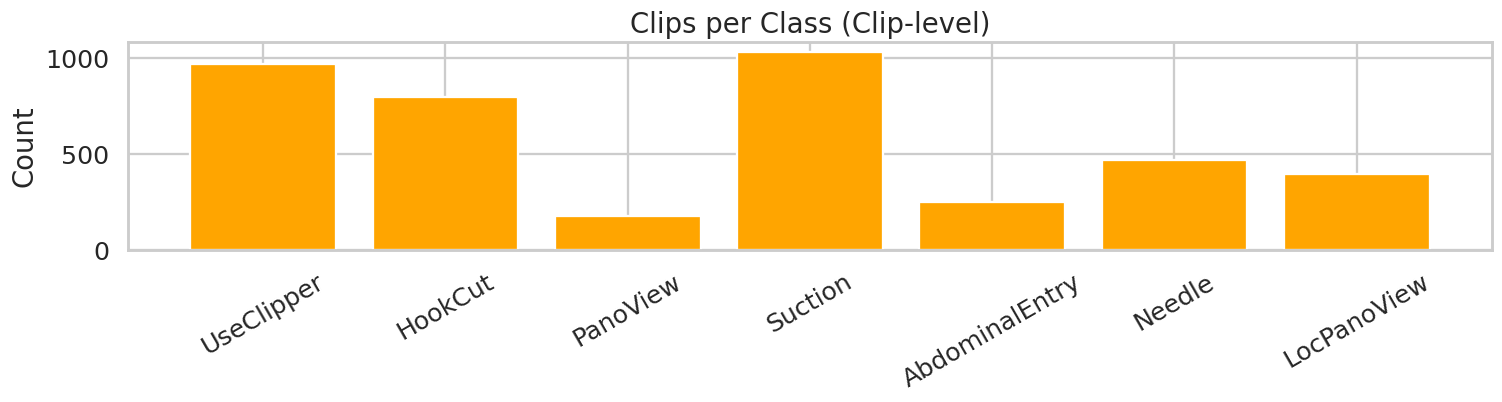

In [ ]:
# compute counts per class and plot with aligned x labels
video_labels = all_df.groupby('base_video')['label'].first().reset_index()

# use a fixed class order so all charts line up
class_order = list(LABEL_DICT.keys())  # ['UseClipper','HookCut','PanoView','Suction','AbdominalEntry','Needle','LocPanoView']
videos_per_class = video_labels['label'].value_counts().reindex(class_order, fill_value=0)
clips_per_class  = all_df['label'].value_counts().reindex(class_order, fill_value=0)

# quick table to see raw counts in the same order
display(pd.DataFrame({
    'videos_per_class': videos_per_class,
    'clips_per_class': clips_per_class,
}, index=class_order).fillna(0).astype(int))

# explicit x positions keep labels centered and consistent
x = np.arange(len(class_order))

fig, axes = plt.subplots(1, 1, figsize=(14, 4), sharex=True)

# show clip-level distribution per class
axes.bar(x, clips_per_class.values, color='orange', align='center')
axes.set_title('Clips per Class (Clip-level)')
axes.set_ylabel('Count')
axes.set_xticks(x)
axes.set_xticklabels(class_order, rotation=30, ha='center')

plt.tight_layout()
plt.show()

Duration (frames) summary on sample:
{
  "count": 350,
  "min": 30,
  "max": 31,
  "mean": 30.428571428571427,
  "median": 30.0,
  "p10": 30.0,
  "p90": 31.0
}


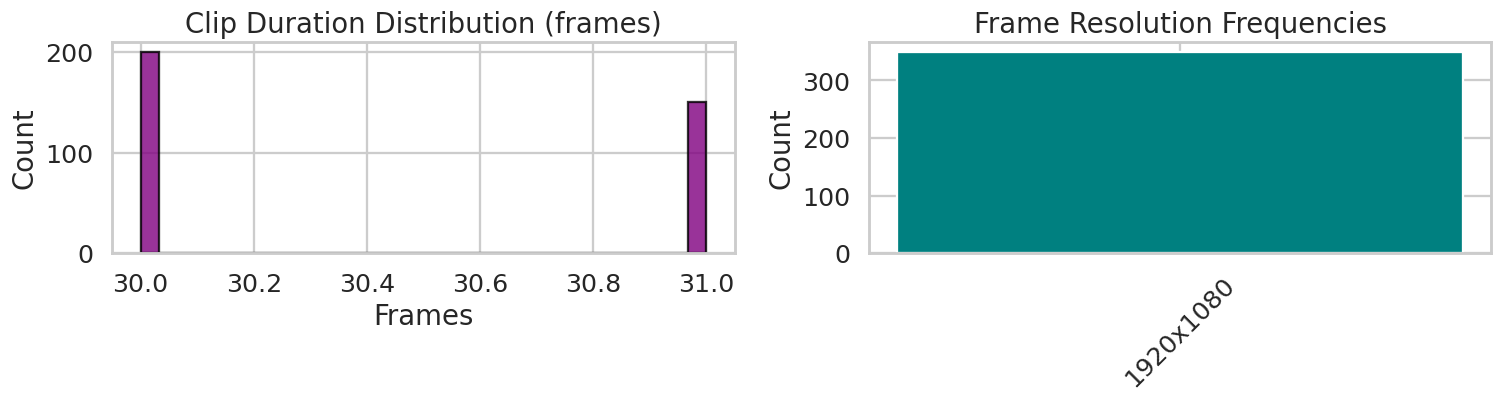

In [ ]:
# sample a subset to estimate durations and resolutions quickly
SAMPLE_MAX = 350  # increase for more precise stats, may be slower
SAMPLE_FILES = all_df.sample(n=min(SAMPLE_MAX, len(all_df)), random_state=42).reset_index(drop=True)

# we'll accumulate simple stats for duration and resolution
durations = []  # number of frames per clip
resolutions = []  # (width, height) per clip
failed_paths = []

for _, row in SAMPLE_FILES.iterrows():
    rel = row['file_path']
    vpath = os.path.join(CLIPS_DIR, rel)
    try:
        with av.open(vpath) as container:
            stream = container.streams.video[0]
            # count frames by decoding; acceptable here since we're sampling
            n_frames = 0
            w = stream.width
            h = stream.height
            for _ in container.decode(video=0):
                n_frames += 1
            durations.append(n_frames)
            resolutions.append((w, h))
    except Exception as e:
        # keep track of any clips that couldn't be read
        failed_paths.append(rel)

# convert to numpy for quick stats
durations = np.array(durations, dtype=np.int32)
res_arr = np.array(resolutions, dtype=np.int32) if resolutions else np.zeros((0,2), dtype=np.int32)

# simple summary helpers for durations
def summarize_durations(durs):
    if durs.size == 0:
        return {}
    return {
        'count': int(durs.size),
        'min': int(durs.min()),
        'max': int(durs.max()),
        'mean': float(durs.mean()),
        'median': float(np.median(durs)),
        'p10': float(np.percentile(durs, 10)),
        'p90': float(np.percentile(durs, 90)),
    }

summary = summarize_durations(durations)
print("Duration (frames) summary on sample:")
print(json.dumps(summary, indent=2))
if failed_paths:
    print(f"Failed to read {len(failed_paths)} clips (skipped)")

# quick visualizations for durations and resolution frequency
fig, axes = plt.subplots(1, 2, figsize=(14,4))
if durations.size > 0:
    axes[0].hist(durations, bins=30, color='purple', edgecolor='black', alpha=0.8)
    axes[0].set_title('Clip Duration Distribution (frames)')
    axes[0].set_xlabel('Frames')
    axes[0].set_ylabel('Count')
else:
    axes[0].set_title('No duration data')

if res_arr.shape[0] > 0:
    # compute unique WxH modes and how often they occur
    uniq, counts = np.unique(res_arr, axis=0, return_counts=True)
    labels = [f"{w}x{h}" for w,h in uniq]
    axes[1].bar(labels, counts, color='teal')
    axes[1].set_title('Frame Resolution Frequencies')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].set_ylabel('Count')
else:
    axes[1].set_title('No resolution data')

plt.tight_layout()
plt.show()

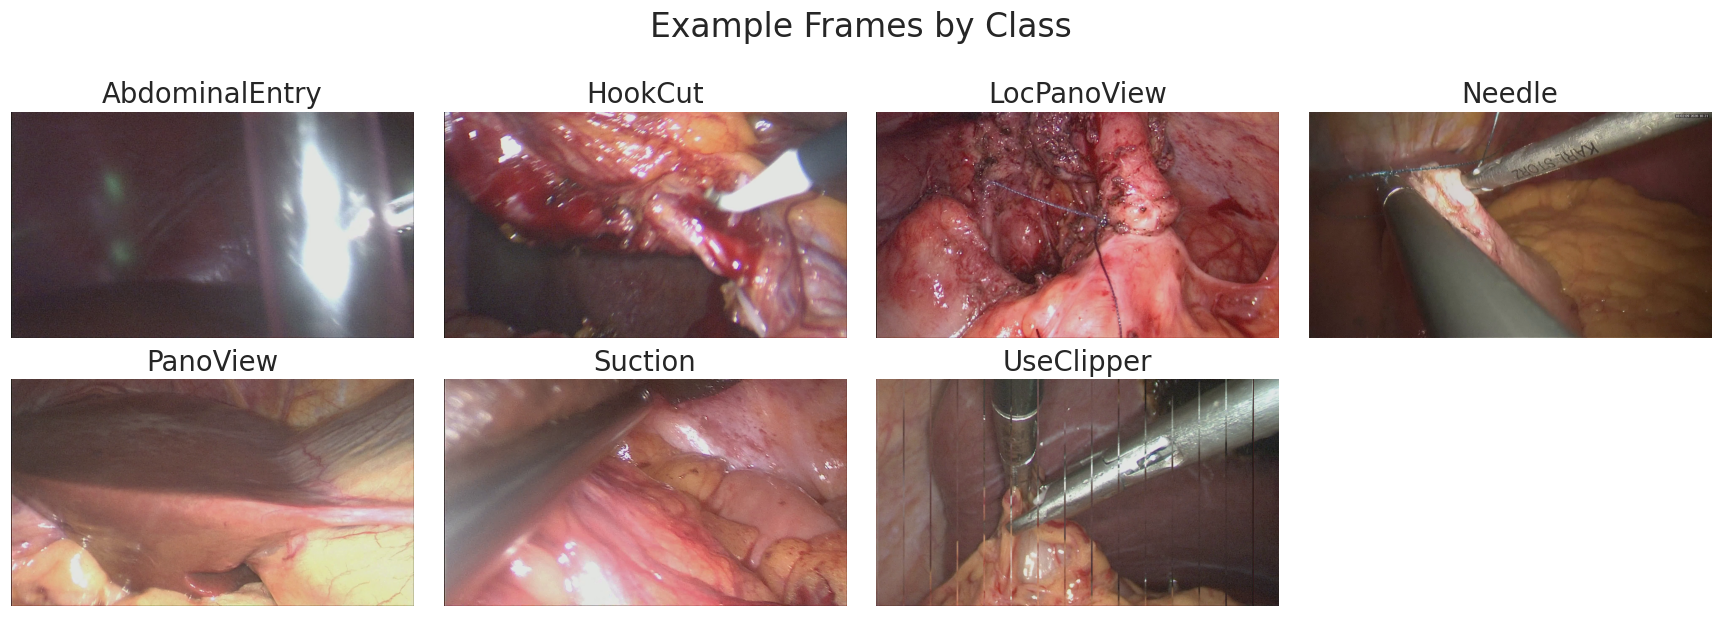

In [ ]:
# show one representative middle frame for each available class
classes = sorted(LABEL_DICT.keys())
examples = {}
for cls in classes:
    subset = all_df[all_df['label'] == cls]
    if subset.empty:
        continue
    # pick a random clip for this class and grab its middle frame
    rel = subset.sample(n=1, random_state=42)['file_path'].iloc[0]
    vpath = os.path.join(CLIPS_DIR, rel)
    mf = middle_frame(vpath)
    if mf is not None:
        examples[cls] = mf

# lay out a small grid that adapts to how many examples we found
n = len(examples)
cols = min(4, n) if n>0 else 1
rows = math.ceil(n / cols) if n>0 else 1
plt.figure(figsize=(4*cols, 3*rows))
for i, (cls, img_np) in enumerate(examples.items(), 1):
    plt.subplot(rows, cols, i)
    plt.imshow(img_np)
    plt.title(cls)
    plt.axis('off')
plt.suptitle('Example Frames by Class')
plt.tight_layout()
plt.show()

## 2) Class Distribution Analysis

Below we assess class imbalance and discuss which classes may be visually similar, affecting model difficulty and augmentation needs.

,Train,Val,Test,All
UseClipper,596,195,177,968
HookCut,583,129,86,798
PanoView,119,39,22,180
Suction,741,98,194,1033
AbdominalEntry,157,63,31,251
Needle,394,27,50,471
LocPanoView,274,51,71,396


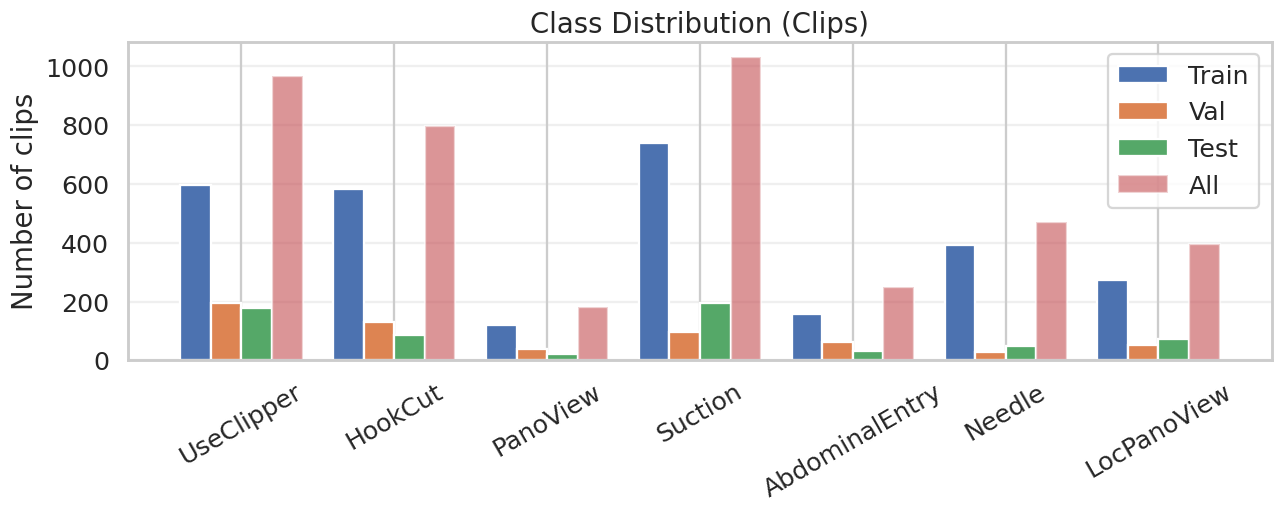

Notes:
- If classes are imbalanced, consider class-weighted loss or targeted augmentation.
- Some classes (e.g., PanoView vs LocPanoView) may be visually similar; consider temporal and context cues.


In [ ]:
# compare class counts across train/val/test and overall

def class_counts(df, order):
    # reindex ensures missing classes get a zero rather than dropping
    return df['label'].value_counts().reindex(order, fill_value=0)

# keep a consistent class order for readability
class_order = list(LABEL_DICT.keys())

train_counts = class_counts(train_df, class_order)
val_counts   = class_counts(val_df, class_order)
test_counts  = class_counts(test_df, class_order)
all_counts   = class_counts(all_df, class_order)

# quick table to scan split balance

display(pd.DataFrame({
    'Train': train_counts,
    'Val': val_counts,
    'Test': test_counts,
    'All': all_counts,
}, index=class_order))

# grouped bars for each class across splits
x = np.arange(len(class_order))
width = 0.2
fig, ax = plt.subplots(figsize=(12,5))
ax.bar(x - 1.5*width, [train_counts[c] for c in class_order], width, label='Train')
ax.bar(x - 0.5*width, [val_counts[c]   for c in class_order], width, label='Val')
ax.bar(x + 0.5*width, [test_counts[c]  for c in class_order], width, label='Test')
ax.bar(x + 1.5*width, [all_counts[c]   for c in class_order], width, label='All', alpha=0.6)
ax.set_xticks(x)
ax.set_xticklabels(class_order, rotation=30)
ax.set_ylabel('Number of clips')
ax.set_title('Class Distribution (Clips)')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 3) Challenges in Surgical Video

- Lighting and brightness variations
- Camera motion 
- Smoke, occlusions, and blood
- Deformable tissue and specular highlights
- Presence/absence of tools and tool changes
- Different surgical scenes and patients

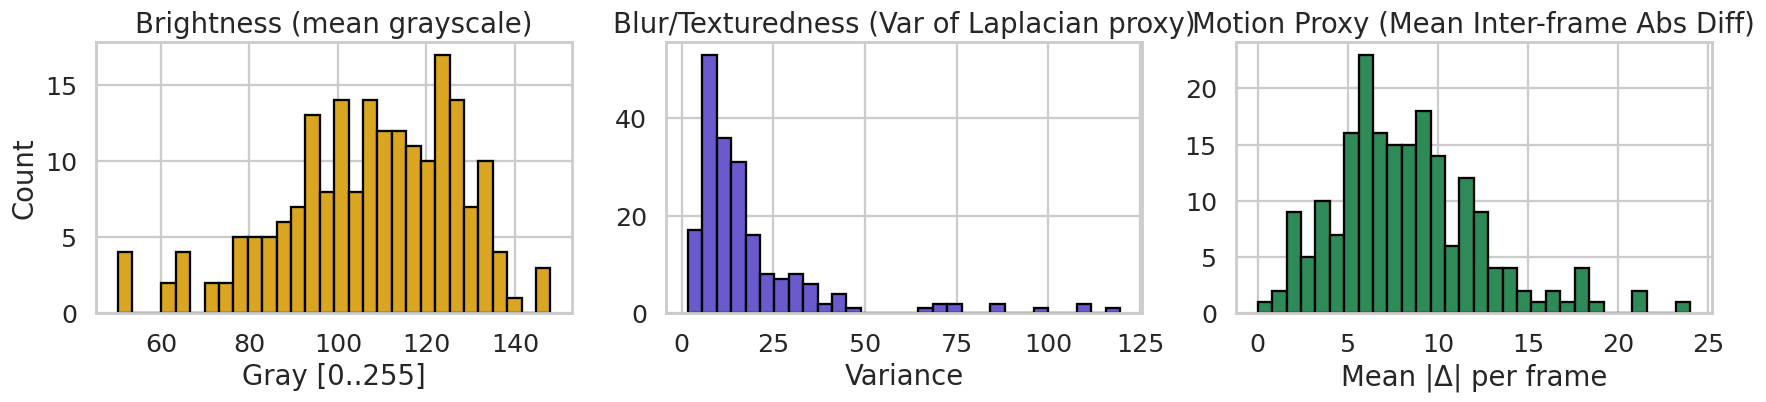

Observations:
- Wide spread of brightness indicates lighting variability.
- Blur/texture variance spread suggests smoke/defocus/occlusion events.
- Motion varies substantially, consistent with PanoView sweeps and tool movements.


In [ ]:
# estimate brightness, blur proxy, and motion proxy on a sample of clips
SAMPLE_MAX_VAR = 200
SAMPLE_VAR = all_df.sample(n=min(SAMPLE_MAX_VAR, len(all_df)), random_state=123).reset_index(drop=True)

brightness_vals = []  # mean grayscale [0,255]
blur_vals = []        # variance of Laplacian (proxy for blur/texturedness)
motion_vals = []      # mean absolute diff between consecutive frames (proxy for motion)

# quick and simple rgb-to-gray conversion
def to_gray(img_np):
    # naive rgb to gray as weighted sum
    return (0.2989*img_np[...,0] + 0.5870*img_np[...,1] + 0.1140*img_np[...,2]).astype(np.float32)

for _, row in SAMPLE_VAR.iterrows():
    rel = row['file_path']
    vpath = os.path.join(CLIPS_DIR, rel)
    try:
        # keep it light: take up to ~16 frames with stride for speed
        frames = read_frames_quick(vpath, max_frames=16, stride=2)
        if len(frames) == 0:
            continue
        grays = [to_gray(f) for f in frames]
        # brightness as the mean gray value across all frames
        b = float(np.mean(grays))
        brightness_vals.append(b)
        # blur proxy: variance of a crude laplacian via second-order gradients on the middle frame
        mid = grays[len(grays)//2]
        lap = np.abs(np.gradient(np.gradient(mid, axis=0), axis=0)) + np.abs(np.gradient(np.gradient(mid, axis=1), axis=1))
        blur_vals.append(float(np.var(lap)))
        # motion proxy: mean absolute difference between consecutive gray frames
        diffs = [np.mean(np.abs(grays[i+1] - grays[i])) for i in range(len(grays)-1)]
        motion_vals.append(float(np.mean(diffs)) if diffs else 0.0)
    except Exception:
        # skip any clip that fails to decode
        continue

# quick histograms to visualize spread
fig, axes = plt.subplots(1, 3, figsize=(16,4))
axes[0].hist(brightness_vals, bins=30, color='goldenrod', edgecolor='black')
axes[0].set_title('Brightness (mean grayscale)')
axes[0].set_xlabel('Gray [0..255]')
axes[0].set_ylabel('Count')

axes[1].hist(blur_vals, bins=30, color='slateblue', edgecolor='black')
axes[1].set_title('Blur/Texturedness (Var of Laplacian proxy)')
axes[1].set_xlabel('Variance')

axes[2].hist(motion_vals, bins=30, color='seagreen', edgecolor='black')
axes[2].set_title('Motion Proxy (Mean Inter-frame Abs Diff)')
axes[2].set_xlabel('Mean |Δ| per frame')

plt.tight_layout()
plt.show()


Brightness:

Noticeable tail to darker frames (under-lit scenes) and lighter ones (specular highlights).
We should consider **brightness/contrast normalization** and mild **color jitter**, monitor exposure-related failure cases.

Blur/Texturedness:

Many clips are relatively smooth/less textured (possible smoke, defocus, motion blur), with fewer highly textured frames.
We need to add robustness via **blur-aware augmentation** ensure models don’t overfit to sharp edges only. 

Motion:

Static phases coexist with substantial camera/tool movement (e.g., PanoView sweeps).
That's why temporal modeling matters (and our models perform generally well TSM, R(2+1)D, CNN+LSTM). We can use **frame-rate jitter** or **temporal cropping** to improve generalization. 


## 4) Temporal Characteristics (time_size = 16 frames)

We analyze how much motion happens within 16 frames and whether actions are separable with short clips. We compute a motion score per clip and visualize per-class distributions and a few clip examples.

/tmp/ipykernel_1813570/1030672912.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


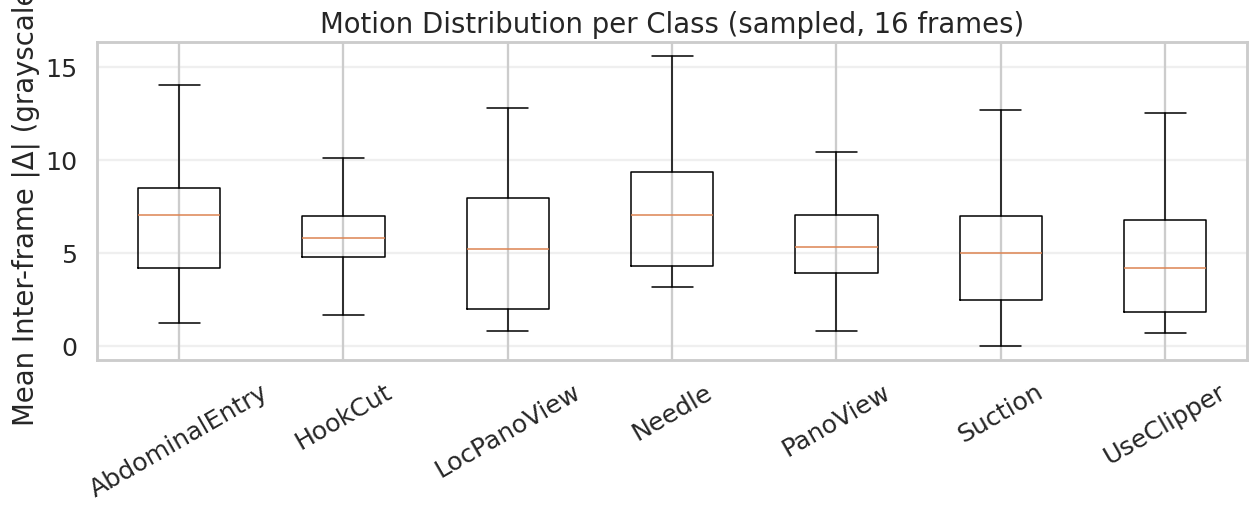

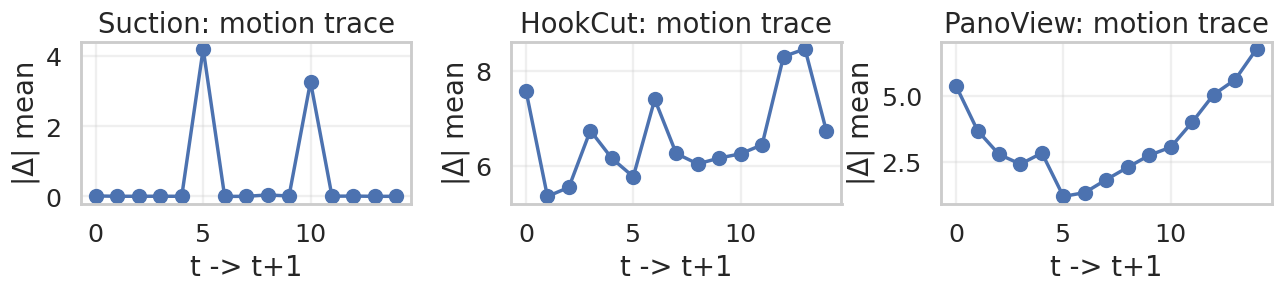

Interpretation:
- Higher motion in PanoView is expected due to sweeping camera moves.
- Tool-centric classes (HookCut, UseClipper) often show sharp localized motion peaks.
- Lower motion in static phases suggests reliance on spatial cues (tissue, tool presence).


In [ ]:
# compute a simple motion score over a 16-frame window and compare across classes
SAMPLE_MAX_MOTION = 300
SAMPLE_MOTION = all_df.sample(n=min(SAMPLE_MAX_MOTION, len(all_df)), random_state=7).reset_index(drop=True)

# average absolute gray-frame difference as a motion score
def motion_score_16(vpath, desired_frames=16):
    frames = read_frames_quick(vpath, max_frames=desired_frames, stride=1)
    if len(frames) < 2:
        return None
    grays = [(0.2989*f[...,0] + 0.5870*f[...,1] + 0.1140*f[...,2]).astype(np.float32) for f in frames]
    diffs = [np.mean(np.abs(grays[i+1]-grays[i])) for i in range(len(grays)-1)]
    return float(np.mean(diffs)) if diffs else 0.0

# gather per-class motion samples for a boxplot
per_class_motion = defaultdict(list)
for _, row in SAMPLE_MOTION.iterrows():
    rel = row['file_path']
    label = row['label']
    vpath = os.path.join(CLIPS_DIR, rel)
    try:
        m = motion_score_16(vpath, desired_frames=16)
        if m is not None:
            per_class_motion[label].append(m)
    except Exception:
        # ignore failures and keep going
        continue

# boxplot of motion per class
data = [per_class_motion[c] for c in sorted(LABEL_DICT.keys())]
labels = list(sorted(LABEL_DICT.keys()))
plt.figure(figsize=(12,5))
plt.boxplot(data, labels=labels, showfliers=False)
plt.ylabel('Mean Inter-frame |Δ| (grayscale)')
plt.title('Motion Distribution per Class (sampled, 16 frames)')
plt.xticks(rotation=30)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# visualize short motion traces for a few example classes
example_classes = ["Suction", "HookCut", "PanoView"]
ncols = len(example_classes)
plt.figure(figsize=(4*ncols, 3))
for i, cls in enumerate(example_classes, 1):
    subset = all_df[all_df['label']==cls]
    if subset.empty:
        continue
    rel = subset.sample(n=1, random_state=10)['file_path'].iloc[0]
    vpath = os.path.join(CLIPS_DIR, rel)
    frames = read_frames_quick(vpath, max_frames=16, stride=1)
    if len(frames) < 2:
        continue
    grays = [(0.2989*f[...,0] + 0.5870*f[...,1] + 0.1140*f[...,2]).astype(np.float32) for f in frames]
    diffs = [np.mean(np.abs(grays[i+1]-grays[i])) for i in range(len(grays)-1)]
    plt.subplot(1, ncols, i)
    plt.plot(diffs, marker='o')
    plt.title(f"{cls}: motion trace")
    plt.xlabel('t -> t+1')
    plt.ylabel('|Δ| mean')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Higher motion in PanoView is expected due to sweeping camera moves.")
print("- Tool-centric classes (HookCut, UseClipper) often show sharp localized motion peaks.")
print("- Lower motion in static phases suggests reliance on spatial cues (tissue, tool presence).")

## 5) Preprocessing & Data Loading Analysis

- Variable-length clips handled by padding/truncation to 16 frames
- RGB conversion and resizing to 768×768 
- Training-time augmentations: Horizontal flip, rotation, color jitter, affine transforms
- Validation/test have deterministic transforms only

Dataset pipeline summary:
- Resize: (224, 224)
- Time size: 16 frames
- Train augmentations: HorizontalFlip(0.5), Rotation(±20°), ColorJitter, RandomAffine, ToTensor
- Val/Test transforms: ToTensor only



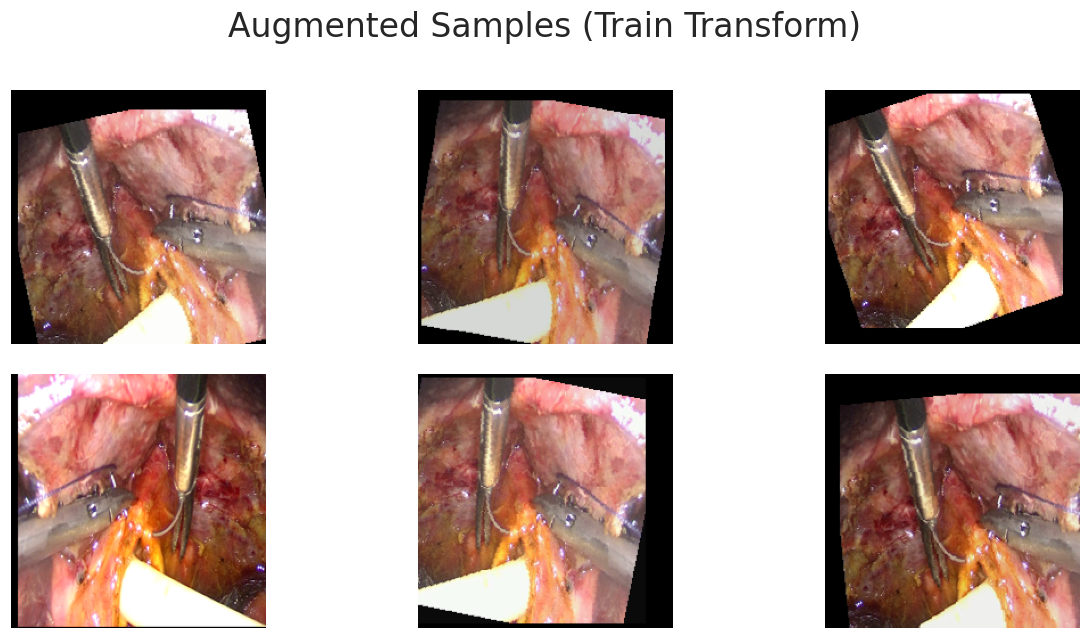

Approx flip rate observed over 200 trials: ~1.00


In [ ]:
# demonstrate dataset transforms and visualize a few augmented examples
from dataset import ClipsDataset, get_train_transform, get_val_transform

# configuration consistent with dataset.py
resize_shape = (224, 224)  # dataset.py default
time_size = 16
train_transform = get_train_transform()
val_transform = get_val_transform()

print("Dataset pipeline summary:")
print(f"- Resize: {resize_shape}")
print(f"- Time size: {time_size} frames")
print("- Train augmentations: HorizontalFlip(0.5), Rotation(±20°), ColorJitter, RandomAffine, ToTensor")
print("- Val/Test transforms: ToTensor only\n")

# pick a single representative frame and show multiple random augmentations
sample_rel = all_df.sample(n=1, random_state=99)['file_path'].iloc[0]
sample_path = os.path.join(CLIPS_DIR, sample_rel)
frame = middle_frame(sample_path)
if frame is None:
    print("Failed to load a sample frame for augmentation demo.")
else:
    pil_base = Image.fromarray(frame).resize(resize_shape)
    aug_images = []
    for _ in range(6):
        # call the train transform repeatedly to see stochastic effects
        aug_images.append(train_transform(pil_base))  # tensor CxHxW
    # plot a small grid of augmented variants
    cols = 3
    rows = 2
    plt.figure(figsize=(4*cols, 3*rows))
    for i, t in enumerate(aug_images, 1):
        plt.subplot(rows, cols, i)
        img = t.permute(1,2,0).numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle('Augmented Samples (Train Transform)')
    plt.tight_layout()
    plt.show()

# estimate how often flips happen (crude heuristic; just to feel the randomness)
if frame is not None:
    pil_base = Image.fromarray(frame).resize(resize_shape)
    flipped = 0
    trials = 200
    for _ in range(trials):
        t = train_transform(pil_base)
        img = (t.permute(1,2,0).numpy()*255).astype(np.uint8)
        # compare left/right halves; bigger difference suggests a flip occurred
        diff = np.mean(np.abs(img[:, :img.shape[1]//2] - img[:, img.shape[1] - img.shape[1]//2:][:, ::-1]))
        if diff > 15:
            flipped += 1
    print(f"Approx flip rate observed over {trials} trials: ~{flipped/trials:.2f}")

## Summary and Next Steps

- The dataset exhibits class imbalance and significant visual variability (lighting, blur/smoke, motion).
- Motion within 16 frames varies by class, underscoring the need for temporal modeling (e.g., CNN+LSTM).
- Preprocessing choices (resize 768×768, time_size=16) and augmentations are appropriate for robustness.
